https://github.com/tristandeleu/pytorch-meta/blob/master/examples/maml/train.py
https://github.com/learnables/learn2learn/blob/master/examples/vision/maml_miniimagenet.py

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:

import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK']='1'

import glob
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
# os.environ['WANDB_MODE']='offline'
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from albumentations.pytorch import ToTensorV2

import albumentations as A
import monai

from colorama import Fore, Back, Style
c_  = Fore.GREEN
sr_ = Style.RESET_ALL

import time
from collections import defaultdict
import copy
import gc

from utils.meta_dataset import EchoDataset_Meta_heatmap
from utils.train import *
from utils.evaluation import *
from utils.optimizer import *
from utils.utils import *

import wandb
import warnings
import learn2learn as l2l
from learn2learn.data.transforms import (NWays,
                                         KShots,
                                         LoadData,
                                         RemapLabels,
                                         ConsecutiveLabels)

warnings.filterwarnings("ignore")


In [ ]:
### Logging part
import logging
from datetime import datetime
from pytz import timezone
import sys

import random

def log(CFG):
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    def timetz(*args):
        return datetime.now(tz).timetuple()
    tz = timezone('Asia/Seoul')
    logging.Formatter.converter = timetz

    formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
    # log 출력
    stream_handler = logging.StreamHandler()
    stream_handler.setFormatter(formatter)
    logger.addHandler(stream_handler)

    # log를 파일에 출력
    file_handler = logging.FileHandler(os.path.join(CFG['save_path'], f"{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.log"))
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    logger.info(f"python {' '.join(sys.argv)}")
    logger.info("Timezone: " + str(tz))
    logger.info(f"Training Start")
    return logger


In [ ]:
def seed_everything(seed: int=0):    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
seed_everything()

## ⚙️ Configuration

In [ ]:
view2cls_dict = {
    'PLAX': 3,
    'PSAX': 0,
    '2CH': 2,
    '4CH': 2,
}
class cfg:
    def __getitem__(self,key):
        return getattr(self, key)
    def __setitem__(self,key,value):
        return setattr(self, key, value)

    height = 256#480   
    width = 256#640
    view = 'PLAX'
    dataset = 'EchoNetLVH_datasetV2'
    lr = 5e-3
    scheduler = 'None'
    reducelr_factor = 0.99
    min_lr = 1e-5
    device = torch.device('mps')
    epochs = 50
    patience = 100
    batch_size = 16

    all_task_list = ['PLAX','PSAX','4CH', '2CH']
    meta_task_list = ['PLAX']#['PLAX','PSAX','4CH']

    ############## Meta Learing hyperparameter
    shot=20
    fast_lr = 0.01
    meta_batch_size=25 # num task, epoch ... 
    way = 2
    adaptation_steps=1
    # num_iterations=60000,
    ############## Heatmap hyperparameter
    std = 15
    ##############
    model = 'UNet'
    backbone = 'resnet101'
    version = 'resnet101'
    
CFG = cfg()
CFG['save_path'] = os.path.join('saved_model', '_'.join([CFG['model'], CFG['version']]))
os.makedirs(CFG['save_path'], exist_ok=True)

In [ ]:
# run = wandb.init(project='2022KOHI_keypoint_detection|Meta Learning',
#                 group=CFG['version'],
#                 name= f"View-{CFG['view']}|Dataset-{CFG['dataset']}|Backbone-{CFG['backbone']}|CFG['version']",
#                 entity='kyh',
#                 # config={k:v for k, v in CFG.items() if '__' not in k}
#                 config={attr: CFG[attr] for attr in dir(CFG) if not callable(getattr(CFG, attr)) and not attr.startswith("__")},
#                 )

# model, hist = run_training(model=model.to(CFG["device"]),
#              train_ds=train_ds, 
#              val_ds=val_ds, 
#              optimizer=optimizer, 
#              scheduler=fetch_scheduler(CFG, optimizer), 
#              criterion=criterion, 
#              CFG=CFG,
#              wandb=wandb)
             
# wandb.run.finish()

In [ ]:
logger = log(CFG)
trace_func = logger.info

2022-11-10 00:37:59,863 - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-7009741c-d8d9-45f3-b554-768deb4d1b22.json


2022-11-10 00:37:59,863 - root - INFO - python /opt/homebrew/Caskroom/miniconda/base/envs/torch/lib/python3.8/site-packages/ipykernel_launcher.py -f /Users/kyh/Library/Jupyter/runtime/kernel-7009741c-d8d9-45f3-b554-768deb4d1b22.json


2022-11-10 00:37:59,867 - Timezone: Asia/Seoul


2022-11-10 00:37:59,867 - root - INFO - Timezone: Asia/Seoul


2022-11-10 00:37:59,868 - Training Start


2022-11-10 00:37:59,868 - root - INFO - Training Start


In [ ]:
dataset_dir = '../meta_dataset/' # 수정필요
CFG['dataset'] = dataset_dir.split('/')[-1]

## ⌗ Load Data

In [ ]:
from albumentations.core.transforms_interface import ImageOnlyTransform

class MinMaxNormalize(ImageOnlyTransform):
    """
    Min-max normalization
    """
    def apply(self, img, **param):
        # minmax normalize
        # img = (img - img.min()) / (img.max() - img.min())
        img = img / 255.
        return img
train_ts = A.Compose([
    A.Resize(CFG['height'], CFG['width']),
    MinMaxNormalize(p=1),

    ToTensorV2(),

],
    keypoint_params=A.KeypointParams(format='xy')
)
test_ts = A.Compose([
        A.Resize(CFG['height'], CFG['width']),
        MinMaxNormalize(p=1),
        ToTensorV2(),
        ],
        keypoint_params=A.KeypointParams(format='xy')
        )


In [ ]:
from utils.meta_dataset import EchoDataset_Meta_heatmap
train_ds = EchoDataset_Meta_heatmap(root=dataset_dir, 
                                    split='train+val', #'train', 
                                    shot=CFG['shot']*2,
                                    transforms=train_ts, 
                                    num_channels=3,
                                    task_list = ['PLAX', '4CH'])
val_ds = EchoDataset_Meta_heatmap(root=dataset_dir, 
                                  split='val', 
                                  shot=CFG['shot'],
                                  transforms=test_ts, 
                                  num_channels=3,
                                  task_list = ['PLAX','4CH'])#set(CFG['all_task_list']).difference(CFG['meta_task_list']))
train_dl = DataLoader(train_ds, batch_size=4, shuffle=False)
val_dl = DataLoader(val_ds, batch_size=2, shuffle=False)


In [ ]:
train_dl.dataset.__len__()

80

## Load Model

In [ ]:
# https://github.com/qubvel/segmentation_models.pytorch
import segmentation_models_pytorch as smp
model = smp.Unet(
    encoder_name=CFG['backbone'],        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    # encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization # 수정필요
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=5,                      # model output channels (number of classes in your dataset)
    activation='softmax'
)

In [ ]:
import learn2learn as l2l
model = l2l.algorithms.MAML(model, lr=CFG['fast_lr'], first_order=False)

In [ ]:
from utils.loss import HeatmapMSELoss, HeatmapOHKMMSELoss, JointsRMSELoss
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG.lr)
criterion = HeatmapMSELoss(use_target_weight=False)

In [ ]:
from utils.heatmaps import *
from utils.utils import *

def fast_adapt(batch, learner, loss, CFG):
    data, labels = batch['data'], batch['label']
    data, labels = data.to(CFG['device']), labels.to(CFG['device'])
    losses = AverageMeter()
    mean_distance_error = AverageMeter()    

    # Separate data into adaptation/evalutation sets
    adaptation_indices = np.zeros(data.size(0), dtype=bool)
    adaptation_indices[np.arange(CFG['shot']*CFG['way']) * 2] = True
    evaluation_indices = torch.from_numpy(~adaptation_indices)
    adaptation_indices = torch.from_numpy(adaptation_indices)
    adaptation_data, adaptation_labels = data[adaptation_indices], labels[adaptation_indices]
    evaluation_data, evaluation_labels = data[evaluation_indices], labels[evaluation_indices]
    
    adaptation_labels = render_gaussian_dot_f(
                adaptation_labels.flip(dims=[2]), # xy 2 yx
                torch.tensor([CFG['std'], CFG['std']], dtype=torch.float32).to(CFG['device']),
                [CFG['height'], CFG['width']],
            ).to(torch.float)
    background = 1 - adaptation_labels.sum(dim=1).unsqueeze(1).clip(0,1)
    adaptation_labels = torch.concat((adaptation_labels,background), 1)
    for step in range(CFG['adaptation_steps']):
        adapatation_error = loss(learner(adaptation_data), adaptation_labels)
        learner.adapt(adapatation_error)
        # losses.update(adapatation_error.item(), evaluation_data.size(0))


    evaluation_labels_heatmap = render_gaussian_dot_f(
                evaluation_labels.flip(dims=[2]), # xy 2 yx
                torch.tensor([CFG['std'], CFG['std']], dtype=torch.float32).to(CFG['device']),
                [CFG['height'], CFG['width']],
            ).to(torch.float)
    background = 1 - evaluation_labels_heatmap.sum(dim=1).unsqueeze(1).clip(0,1)
    # print(evaluation_labels.shape,evaluation_labels_heatmap.shape)
    evaluation_labels_heatmap = torch.concat((evaluation_labels_heatmap,background), 1)
    
    # Adapt the model
    predictions = learner(evaluation_data)
    evaluation_error = loss(predictions, evaluation_labels_heatmap)
    losses.update(evaluation_error.item(), evaluation_data.size(0))
    
    predictions = learner(evaluation_data)
    evaluation_error = loss(predictions, evaluation_labels_heatmap)
    sample = {
        'data': evaluation_data, 
        'label': evaluation_labels
    }
    metric = distance_error(sample, heatmap2argmax(predictions[:,:-1,...]))
    mean_distance_error.update(np.mean(
                            metric
                            ), 
                    evaluation_data.size(0)
    )

    return evaluation_error, mean_distance_error.avg

In [ ]:
from utils.train_metalearning import train_one_epoch, valid_one_epoch
def run_training(model, train_ds, val_ds, optimizer, scheduler, criterion, CFG, wandb):
    """
    모델, 데이터를 받아 학습/검증 수행후 결과에 대해 출력 및 모델 저장
    """
    device = CFG['device']
    num_epochs = CFG['epochs']
    start = time.time()
    early_stopping = EarlyStopping(patience=CFG['patience'], verbose=True, trace_func=trace_func)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_mde = np.inf
    best_metric_epoch = -1

    best_loss = np.inf
    best_loss_epoch = -1

    history = defaultdict(list)
    # 에폭만큼 학습 수행
    
    optimizer.zero_grad()
    train_dl = DataLoader(train_ds, batch_size=1, shuffle=True)

    for epoch in range(1, num_epochs+1):
        del train_dl
        gc.collect()
        train_ds.resample()
        
        model_ = model.clone()
        
        train_dl = DataLoader(train_ds, batch_size=CFG['shot']*CFG['way']*2, shuffle=False)
        batch = train_dl.__iter__().__next__()
        
        evaluation_error, mean_distance_error = fast_adapt(batch, learner=model_, loss=criterion, CFG=CFG)
        evaluation_error.backward()
        early_stopping(evaluation_error, model)
        # for p in model.parameters():
        #     p.grad.data.mul_(1.0 / CFG['epochs'])
        optimizer.step()

        # history['Train Loss'].append(train_loss)
        # history['Train MDE'].append(train_mde)
        # history['Valid Loss'].append(val_loss)
        # history['Valid MDE'].append(val_mde)
        
        # wandb.log({"Train Loss": train_loss, 
        #         "Train MDE": train_mde,
        #         "Valid Loss": val_loss,
        #         "Valid MDE": val_mde,
        #         "LR":scheduler.get_last_lr()[0] if CFG['scheduler'] != 'None' else optimizer.param_groups[0]['lr']
        #     }
        #     )

        # trace_func(f"[Epoch {epoch}/{CFG['epochs']}: Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Train MDE: {train_mde:.5f}, Val MDE: {val_mde:.5f}")
        
        # if scheduler is not None:
        #     scheduler.step()

        # # Val MDE가 개선된 경우
        # if val_mde <= best_mde:
        #     trace_func(f"Valid Score Improved ({best_mde:.4f} ---> {val_mde:.4f})")
        #     best_mde = val_mde
        #     best_metric_epoch = epoch
        #     best_metric_model_wts = copy.deepcopy(model.state_dict())
            
        #     wandb.run.summary['Best MDE'] = best_mde
        #     wandb.run.summary['Best Metric Epoch'] = best_metric_epoch

        #     model_name = f"best_metric_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict':optimizer.state_dict(),
        #         'loss': val_loss,
        #         'metric': val_mde
        #         }, 
        #         os.path.join(CFG['save_path'], model_name))

        #     trace_func(f"Model Saved")

        # # Loss 개선되었을때
        # if val_loss <= best_loss:
        #     trace_func(f"Valid Loss Importved ({best_loss:.4f} ---> {val_loss:.4f})")
        #     best_loss = val_loss
        #     best_loss_epoch = epoch
        #     best_loss_model_wts = copy.deepcopy(model.state_dict())

        #     wandb.run.summary['Best MDE'] = best_mde
        #     wandb.run.summary['Best Loss Epoch'] = best_loss_epoch


        #     model_name = f"best_loss_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
        #     torch.save({
        #         'epoch': epoch,
        #         'model_state_dict': model.state_dict(),
        #         'optimizer_state_dict':optimizer.state_dict(),
        #         'loss': val_loss,
        #         'metric': val_mde
        #         }, 
        #         os.path.join(CFG['save_path'], model_name))
        print(mean_distance_error)       
        if early_stopping.early_stop:
            trace_func("Early stopping")
            break

    model_name = f"last_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
    torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict':optimizer.state_dict(),
                'loss': evaluation_error, 
                'metric': mean_distance_error

                }, 
                os.path.join(CFG['save_path'], model_name))
    
    end = time.time()
    time_elapsed = end-start
    trace_func("Trianing complete in {:.0f}h {:.0f}m {:.0f}s".format(time_elapsed//3600, (time_elapsed%3600)//60, (time_elapsed%3600)%60))
    trace_func("Best Val MDE: {:.4f}".format(best_loss))
    trace_func("Best Val Loss: {:.4f}".format(best_mde))

    # model.load_state_dict(best_metric_model_wts)

    return model, history

In [ ]:
# from utils.train_metalearning import train_one_epoch, valid_one_epoch
# def run_training(model, train_ds, val_ds, optimizer, scheduler, criterion, CFG, wandb):
#     """
#     모델, 데이터를 받아 학습/검증 수행후 결과에 대해 출력 및 모델 저장
#     """
#     device = CFG['device']
#     num_epochs = CFG['epochs']
#     start = time.time()
#     early_stopping = EarlyStopping(patience=CFG['patience'], verbose=True, trace_func=trace_func)

#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_mde = np.inf
#     best_metric_epoch = -1

#     best_loss = np.inf
#     best_loss_epoch = -1

#     history = defaultdict(list)
#     # 에폭만큼 학습 수행
    
#     optimizer.zero_grad()
#     train_dl = DataLoader(train_ds, batch_size=CFG['shot'], shuffle=True)
#     val_dl = DataLoader(val_ds, batch_size=CFG['shot'], shuffle=False)

#     for epoch in range(1, num_epochs+1):
#         del train_dl,val_dl
#         gc.collect()
#         train_ds.resample()
#         val_ds.resample()
#         model_ = model.clone()
        
#         train_dl = DataLoader(train_ds, batch_size=CFG['shot']*2, shuffle=True)
#         train_loss, train_mde, _ = train_one_epoch(model=model_, dataloader=train_dl, optimizer=optimizer, scheduler=scheduler, device=device, criterion=criterion, CFG=CFG)

#         model_ = model.clone()
#         val_dl = DataLoader(val_ds, batch_size=CFG['shot']*2, shuffle=False)
#         val_loss, val_mde = valid_one_epoch(model=model_, dataloader=val_dl, device=device, criterion=criterion, CFG=CFG)
#         early_stopping(val_loss, model)
#         # for p in model.parameters():
#         #     p.grad.data.mul_(1.0 / CFG['epochs'])
#         optimizer.step()

#         history['Train Loss'].append(train_loss)
#         history['Train MDE'].append(train_mde)
#         history['Valid Loss'].append(val_loss)
#         history['Valid MDE'].append(val_mde)
        
#         wandb.log({"Train Loss": train_loss, 
#                 "Train MDE": train_mde,
#                 "Valid Loss": val_loss,
#                 "Valid MDE": val_mde,
#                 "LR":scheduler.get_last_lr()[0] if CFG['scheduler'] != 'None' else optimizer.param_groups[0]['lr']
#             }
#             )

#         trace_func(f"[Epoch {epoch}/{CFG['epochs']}: Train Loss: {train_loss:.5f}, Val Loss: {val_loss:.5f}, Train MDE: {train_mde:.5f}, Val MDE: {val_mde:.5f}")
        
#         if scheduler is not None:
#             scheduler.step()

#         # Val MDE가 개선된 경우
#         if val_mde <= best_mde:
#             trace_func(f"Valid Score Improved ({best_mde:.4f} ---> {val_mde:.4f})")
#             best_mde = val_mde
#             best_metric_epoch = epoch
#             best_metric_model_wts = copy.deepcopy(model.state_dict())
            
#             wandb.run.summary['Best MDE'] = best_mde
#             wandb.run.summary['Best Metric Epoch'] = best_metric_epoch

#             model_name = f"best_metric_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict':optimizer.state_dict(),
#                 'loss': val_loss,
#                 'metric': val_mde
#                 }, 
#                 os.path.join(CFG['save_path'], model_name))

#             trace_func(f"Model Saved")

#         # Loss 개선되었을때
#         if val_loss <= best_loss:
#             trace_func(f"Valid Loss Importved ({best_loss:.4f} ---> {val_loss:.4f})")
#             best_loss = val_loss
#             best_loss_epoch = epoch
#             best_loss_model_wts = copy.deepcopy(model.state_dict())

#             wandb.run.summary['Best MDE'] = best_mde
#             wandb.run.summary['Best Loss Epoch'] = best_loss_epoch


#             model_name = f"best_loss_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
#             torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict':optimizer.state_dict(),
#                 'loss': val_loss,
#                 'metric': val_mde
#                 }, 
#                 os.path.join(CFG['save_path'], model_name))

#         if early_stopping.early_stop:
#             trace_func("Early stopping")
#             break

#     model_name = f"last_epoch-{CFG['view']}-{CFG['dataset']}-{CFG['backbone']}.pth"
#     torch.save({
#                 'epoch': epoch,
#                 'model_state_dict': model.state_dict(),
#                 'optimizer_state_dict':optimizer.state_dict(),
#                 'loss': val_loss,
#                 'metric': val_mde

#                 }, 
#                 os.path.join(CFG['save_path'], model_name))
    
#     end = time.time()
#     time_elapsed = end-start
#     trace_func("Trianing complete in {:.0f}h {:.0f}m {:.0f}s".format(time_elapsed//3600, (time_elapsed%3600)//60, (time_elapsed%3600)%60))
#     trace_func("Best Val MDE: {:.4f}".format(best_loss))
#     trace_func("Best Val Loss: {:.4f}".format(best_mde))

#     model.load_state_dict(best_metric_model_wts)

#     return model, history

In [ ]:
CFG['device'] = 'cpu'

## Train

In [ ]:
run = wandb.init(project='2022KOHI_keypoint_detection|Meta Learning',
                group=CFG['version'],
                name= f"View-{CFG['view']}|Dataset-{CFG['dataset']}|Backbone-{CFG['backbone']}|CFG['version']",
                entity='kyh',
                # config={k:v for k, v in CFG.items() if '__' not in k}
                config={attr: CFG[attr] for attr in dir(CFG) if not callable(getattr(CFG, attr)) and not attr.startswith("__")},
                )

model, hist = run_training(model=model.to(CFG["device"]),
             train_ds=train_ds, 
             val_ds=val_ds, 
             optimizer=optimizer, 
             scheduler=fetch_scheduler(CFG, optimizer), 
             criterion=criterion, 
             CFG=CFG,
             wandb=wandb)
             
wandb.run.finish()

## test

In [ ]:
val_it = train_dl.__iter__()

In [ ]:
val_elem = val_it.next()

In [ ]:
# model.eval()
result = model.to(torch.device('cpu'))(val_elem['data'])

In [ ]:
from utils.heatmaps import *
heatmap = render_gaussian_dot_f(
    val_elem['label'][0:1].flip(dims=[2]), # xy 2 yx
    torch.tensor([CFG['std'], CFG['std']], dtype=torch.float32).to('cpu'),
    [CFG['height'], CFG['width']],
    # mul=255.
    )


In [ ]:
x = val_elem['label'].squeeze()

(-0.5, 255.5, 255.5, -0.5)

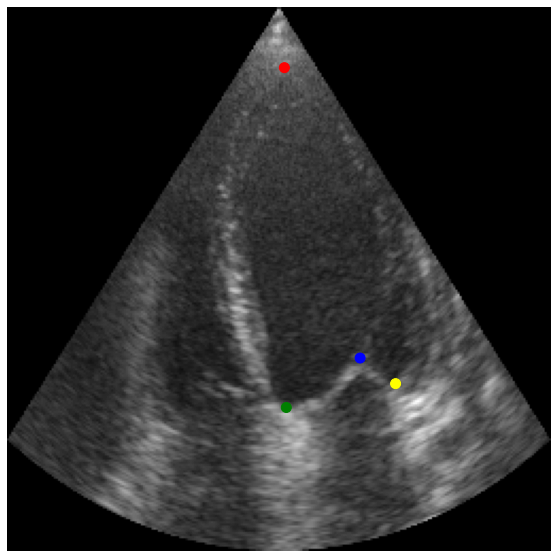

In [ ]:
plt.figure(figsize=(15,10))

plt.imshow(val_elem['data'][0,0,...].numpy(), cmap='gray')
plt.scatter(x[0][:,0], x[0][:,1], c=['red', 'blue', 'green', 'yellow'], s=100)
plt.axis('off')

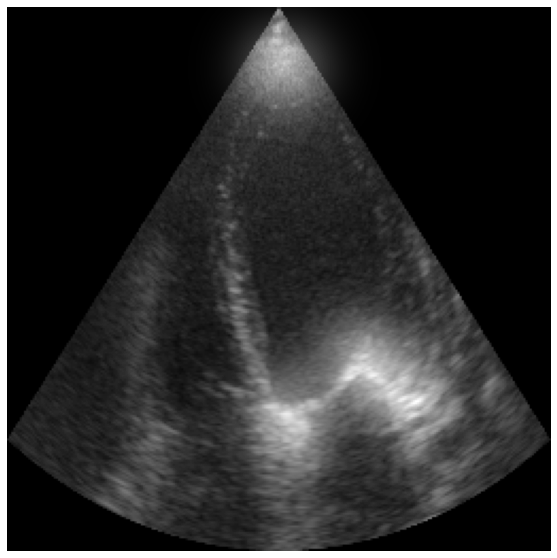

In [ ]:
import cv2
i = cv2.addWeighted(val_elem['data'][0,0,...].numpy(),1,heatmap.squeeze().sum(0).numpy(),.5,0)

plt.figure(figsize=(15,10))
plt.axis('off')
plt.imshow(i, cmap='gray')

In [ ]:
background = 1 - heatmap.sum(dim=1).unsqueeze(1).clip(0,1)
heatmap = torch.concat((heatmap,background), 1)

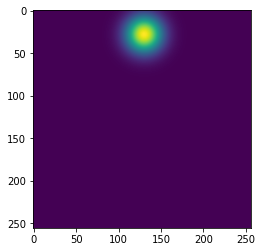

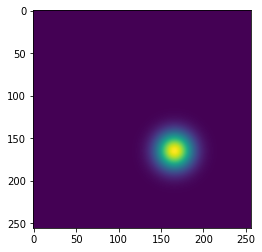

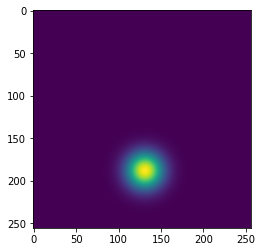

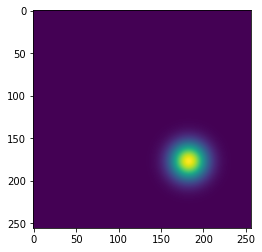

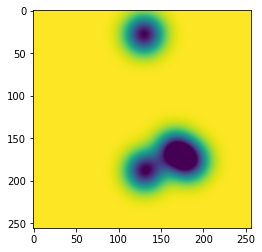

In [ ]:
for i in heatmap.squeeze():
    plt.imshow(i)
    plt.show()
    # print((i==i.max()).nonzero())

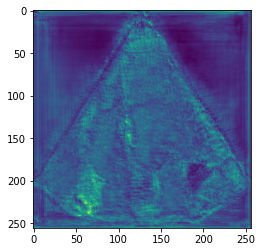

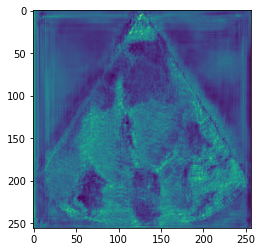

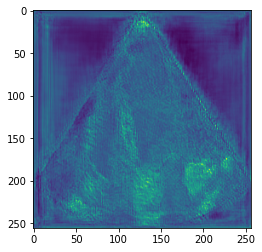

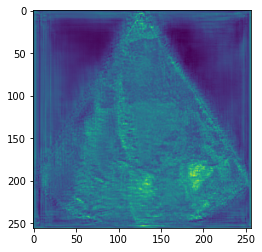

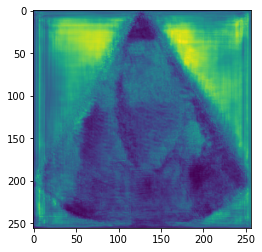

In [ ]:
predicted = []
for i in result[0].squeeze():
    a = i.detach().clone().numpy()
    # print(a)
    # a[a<=.3]=0
    
    plt.imshow(a)
    plt.show()
    predicted.append((a==a.max()).nonzero())
